# Continuum + Iron Fitting

In [114]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as fits
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.optimize import curve_fit

Opening up a quasar spectrum

In [115]:
spec = fits.open('../../Programs:Coding/spec-0266-51630-0053.fits')
z = spec[2].data['Z']
flux = spec[1].data['flux'] / (1+z)
wav = 10**spec[1].data['loglam'] / (1+z)
ivar = spec[1].data['ivar']

In [116]:
civ_ix = (wav > 1435) & (wav < 1710)
flux = flux[civ_ix]
wav = wav[civ_ix]
ivar = ivar[civ_ix]
sig = 1/np.sqrt(abs(ivar))

Let's also load in the iron template file, in log space. I'm using Pandas to read in data, but you can use whatever you're familiar with.

In [148]:
iron_template = pd.read_csv('../../Fe_UVtemplt_A.dat', delim_whitespace=True)
iron_wav = iron_template['wavelength'].values
iron_flux = iron_template['flux'].values

Let's plot the template:

Text(0.5, 0, 'wavelength')

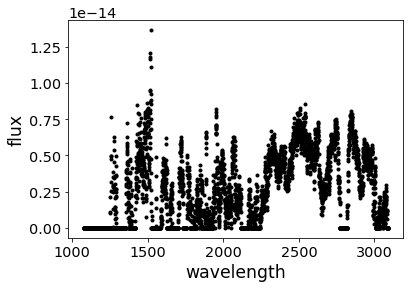

In [149]:
plt.plot(iron_wav, iron_flux, 'k.')
plt.ylabel('flux')
plt.xlabel('wavelength')

Now for the actual fitting. Let's define a Gaussian where the dispersion will instead be the broadened sigma from Vestergaard+(2001).

In [158]:
def gaussian(x, mu, sigma):
    sigma_conv = np.sqrt(sigma**2 - 900**2) / (2 * np.sqrt(2 * np.log(2)))
    return np.exp(- (x - mu)**2 / (2 * sigma_conv**2))

Next, let's define a function that "rebins" our wavelengths so they are spaced logarithmically. Vestergaard+(2001) says that convolution should be done with log spacing.

In [159]:
def rebin_logspace(x, y):
    log_x = np.log10(x)
    new_x = np.logspace(log_x[1], log_x[-1], len(x))
    return new_x, interp1d(x, y)

def rebin_linspace(x, y):
    new_x = np.linspace(x[1], x[-1], len(x))
    return new_x, interp1d(x, y)

In [160]:
log_iron_wav, log_iron_spline = rebin_logspace(iron_wav, iron_flux)

Finally, let's define a functional form for the continuum. We were doing a straight line fit before when we should have been doing a straight line in log-log space (which is a power-law in linear space). Our function will have the form:

$$A \lambda^k + 10^B F_{iron},$$
where $F_{iron}$ is the convolved iron template, and $10^B$ is the normalization for the iron template ($B$ itself ends up being very small)

In [161]:
def fitting_function(lam, A, k, B, mu, sigma):
    global log_wav
    global ix
    iron_convolution = np.convolve(log_iron_spline(log_wav), gaussian(log_wav, mu, sigma), mode='same')
    return (A * lam**k) + (10**B * iron_convolution[ix])

Let's use scipy curve_fit now, and do the fitting for CIV. We should specify bounds for each parameter we're fitting (for example, $A$ should be greater than zero, and probably less than 100). We should also specify initial estimates for each parameter, which we put into $p0$.

In [163]:
bounds = [[0, -2, 10, 1500, 0], [100, 2, 20, 1600, 10000]]
p0 = [10, 0, 14, 1550, 1000] 

log_wav, log_flux = rebin_logspace(wav, flux)
ix = ((log_wav > 1435)&(log_wav < 1465)) | ((log_wav > 1690)&(log_wav < 1710))

pf, covariances = curve_fit(fitting_function, log_wav[ix], log_flux(log_wav[ix]), sigma=sig[ix], bounds=bounds, p0=p0)

/home/ray/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


curve_fit outputs the best fit estimates for each parameter, as well as the covariance matrix. We can now do the continuum subtraction and print out the best fit parameters:

[['A' '31.245012670646094']
 ['k' '-0.40794907994641333']
 ['B' '13.265845066861523']
 ['mu' '1580.969307110633']
 ['sigma' '900.0000084506265']]


(0, 4)

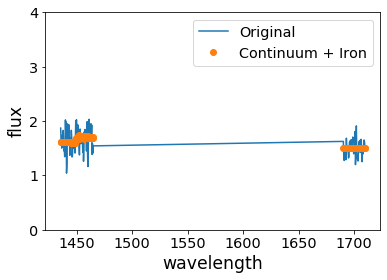

In [165]:
continuum_flux = fitting_function(log_wav[ix], *pf)

plt.plot(log_wav[ix], log_flux(log_wav[ix]), label="Original")
plt.plot(log_wav[ix], continuum_flux, 'o', label='Continuum + Iron')

plt.legend()
plt.ylabel('flux')
plt.xlabel('wavelength')

print(np.array([['A', 'k', 'B', 'mu', 'sigma'], pf]).T)

plt.ylim(0,4)

That's what the fit looks like, now what does it look like when we subtract it from the spectral line?

(-1, 4)

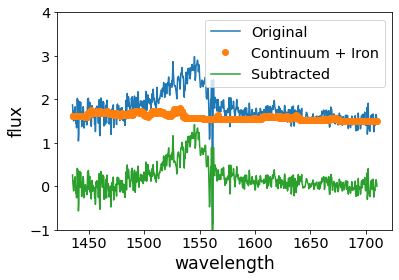

In [167]:
ix = (log_wav > 1435) & (log_wav < 1710)

continuum_flux = fitting_function(log_wav, *pf)

plt.plot(log_wav, log_flux(log_wav), label="Original")
plt.plot(log_wav, continuum_flux, 'o', label='Continuum + Iron')

plt.plot(log_wav, log_flux(log_wav) - continuum_flux, label='Subtracted')
plt.legend()
plt.ylabel('flux')
plt.xlabel('wavelength')

plt.ylim(-1,4)

Finally, since we rebinned our data into log spacing to do the subtraction, we need to convert back to linear spacing. I can plot what that transformation does, too.

(-1, 4)

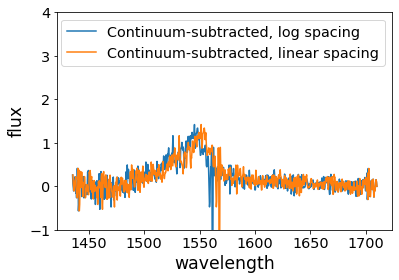

In [168]:
subtracted_log_flux = log_flux(log_wav) - continuum_flux

lin_wav, lin_flux = rebin_linspace(log_wav, subtracted_log_flux)

plt.plot(log_wav, log_flux(log_wav) - continuum_flux, label='Continuum-subtracted, log spacing')
plt.plot(lin_wav, lin_flux(log_wav), label='Continuum-subtracted, linear spacing')
plt.legend()
plt.ylabel('flux')
plt.xlabel('wavelength')

plt.ylim(-1,4)